## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import re
from tqdm import tqdm
from random import sample


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
device

'cuda:0'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [5]:
len(set(text))

38

### Data loading: "Евгений Онегин"


In [5]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    russian_text = iofile.readlines()
    
russian_text = [x.replace('\t\t', '') for x in russian_text]

--2021-12-22 13:11:02--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.3’

onegin.txt.3        100%[===================>] 256,37K   754KB/s    in 0,3s    

2021-12-22 13:11:03 (754 KB/s) - ‘onegin.txt.3’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.

russian_text = ''.join(russian_text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [7]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [8]:
# assert not '|' in tokens, (
#     'special token must not be in tokens'
# )
# pad = '|'
# tokens += [pad]
# len(tokens)

In [9]:
token_to_idx = {char: idx for idx, char in enumerate(tokens)}
idx_to_token = {idx: char for idx, char in enumerate(tokens)}

MAX_LENGTH = 100

sequences = text.split('\n')
sequences = [seq.strip(' ') + '\n' for seq in sequences]
all_sequences = ''.join(sequences)
sequences = []

for i in range(len(all_sequences) - MAX_LENGTH):
    sequences.append(all_sequences[i:(i + MAX_LENGTH)])

assert len(set(map(len, sequences))) == 1, (
    "All sequences must be same length"
)

In [10]:
print(f"MAX_LENGTH: {MAX_LENGTH}")
sequences[:10]

MAX_LENGTH: 100


["from fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the ri",
 "rom fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the rip",
 "om fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the ripe",
 "m fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the riper",
 " fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the riper ",
 "fairest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the riper s",
 "airest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the riper sh",
 "irest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the riper sho",
 "rest creatures we desire increase,\nthat thereby beauty's rose might never die,\nbut as the riper shou",
 "est creatures we desire increase,\n

In [15]:
def to_matrix(sequences, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = MAX_LENGTH
    seq_ix = np.zeros([len(sequences), max_len], dtype)

    for i, seq in enumerate(sequences):
        line_ix = [token_to_idx[c] for c in seq]
        seq_ix[i, :] = line_ix
        
    if not batch_first:
        names_ix = np.transpose(seq_ix)

    return seq_ix

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [37]:
class VanilaRNN(nn.Module):
    
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=512):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        x_emb = self.embedding(x).to(device)
        h_prev = torch.tensor(h_prev).to(device)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, nn.functional.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)
    
def rnn_loop(model, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = model(x_t, hid_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

def generate_text(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = model.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = model(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = model(x_sequence[:, -1], hid_state)
        p_next = nn.functional.softmax(logp_next.detach() / temperature, dim=-1).data.detach().to('cpu').numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(dict_size, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.to('cpu').numpy()[0]])

In [38]:
dict_size = len(token_to_idx)
hidden_dim = 1024
n_layers = 15

model_rnn = VanilaRNN()
model_rnn = model_rnn.to(device)

n_epochs = 50000
lr=0.01

loss_func = nn.NLLLoss()
optimizer = torch.optim.SGD(model_rnn.parameters(), lr=lr)

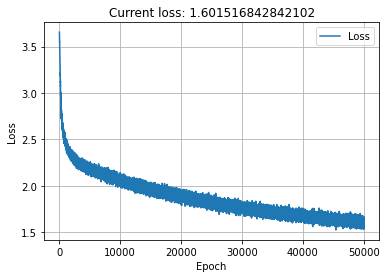

100%|██████████| 50000/50000 [32:26<00:00, 25.69it/s]

Test text: ' there are my store the prove shall my stake i do all is the love shall then thee more fair stors bu'


In [39]:
train_loss_lst = []
plot_tick = 100

for i in tqdm(range(n_epochs)):
    batch_ix = to_matrix(sample(sequences, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq = rnn_loop(model_rnn, batch_ix)
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(predictions_logp.reshape(-1, dict_size), actual_next_tokens.reshape(-1))
    
    # train with backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss_lst.append(loss.data.to('cpu').numpy())

    if (i + 1) % plot_tick == 0:
        clear_output(True)
        plt.plot(train_loss_lst, label='Loss')
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f"Current loss: {np.mean(train_loss_lst[-plot_tick:])}")
        plt.show()
        
        test_text = generate_text(model_rnn, seed_phrase=' there are', max_length=MAX_LENGTH, temperature=0.5)
        print(f"Test text: '{test_text}'")

assert np.mean(train_loss_lst[:10]) > np.mean(train_loss_lst[-10:]), "RNN didn't converge."

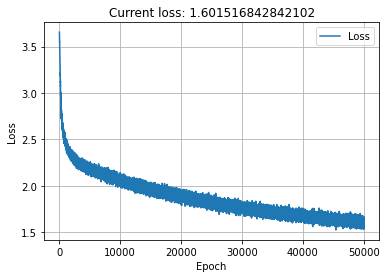

In [40]:
plt.plot(train_loss_lst, label='Loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Current loss: {np.mean(train_loss_lst[-plot_tick:])}")
plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [41]:
seed_text = sequences[0][:13]
print('Real text:\n')
print(sequences[0])
seed_text = ''.join(seed_text)
print(f'text seed: {seed_text}')

Real text:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the ri
text seed: from fairest 


In [42]:
length = 500
temperature_lst = [0.1, 0.2, 0.5, 1.0, 2.0]
for temperature in temperature_lst:
    print(f"Temperature: {temperature}\nText:\n")
    print(generate_text(model_rnn, seed_text, length, temperature))
    print()

Temperature: 0.1
Text:

from fairest the world in the store the world the the world with the still in the store the world with the still dear thee and the strange the world in the seem the stare the world in the seem the world the store the world in the stare the world in the seem shall the world in the stare the store the stare the world in the seem the store the stare the will my love the world in the see my love the stard the store the store the world in my see my love the store the stare the world the store the wor

Temperature: 0.2
Text:



/home/aslan/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


from fairest the summer the store the stare the world with the summer the world i do i do should make the stare the world in the store the world with the store is the store the praise,
and the seem the world in the seep the summer the with the stall deart the summer the words and the still shall beauty spear the love the world in the stand the strange to be thee the the thee thee that the still my seep the still in the still still shall the the world with the stare i seep thou art the sure the w

Temperature: 0.5
Text:

from fairest with his stards
and the faires thou art the words comming with the with mine and to thy seem for me that he worth the wost me such can your shall my wate,
and beauty looks,
and mine eyes for the painter thee hath shall lives thy self and fried born the every same the forth so dredse upon thy see which the sweet then so my so sure world his store bearts beauted,
that i day slows when i world is not so more, nor the have the world i have the worth, and the su

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [16]:
class LSTM(nn.Module):
    
    def __init__(self, num_tokens=len(token_to_idx), embedding_size=64, hidden_size=1024):
        super(self.__class__,self).__init__()
        self.num_units = hidden_size
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.linear_1 = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.linear_2 = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.linear_3 = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.linear_4 = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.rnn_to_logits = nn.Linear(hidden_size, num_tokens)
        
    def forward(self, x, h_prev, c_prev):
        """
        This method computes h_next, c_next from (x, h_prev, c_prev) and log P(x_next | h_next, c_prev)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        :param c_prev: previous memory state, containing matrix [batch, rnn_num_units] of float32
        """
        x_emb = self.embedding(x).to(device)
        h_prev = torch.tensor(h_prev).to(device)
        c_prev = torch.tensor(c_prev).to(device)
        # c_prev = torch.tensor(c_prev).to(device)
        # x_and_c = torch.cat([x_emb, c_prev], dim=-1)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        c_next = self.linear_1(x_and_h)
        c_next = torch.sigmoid(c_next)
        c_next = torch.mul(c_prev, c_next)
        c_next_2 = self.linear_2(x_and_h)
        c_next_2 = torch.sigmoid(c_next_2)
        c_next_3 = self.linear_3(x_and_h)
        c_next_3 = torch.tanh(c_next_3)
        c_next_3 = torch.mul(c_next_2, c_next_3)
        c_next = torch.add(c_next, c_next_3)
        
        h_next = self.linear_4(x_and_h)
        h_next = torch.sigmoid(h_next)
        h_next_1 = torch.tanh(c_next)
        h_next = torch.mul(h_next, h_next_1)
        
        assert h_next.size() == h_prev.size(), (
            f"h_prev: {h_prev.size()}, h_next: {h_next.size()}"
        )
        assert c_next.size() == c_prev.size(), (
            f"c_prev: {c_prev.size()}, c_next: {c_next.size()}"
        )
        
        logits = self.rnn_to_logits(h_next)
        logits = nn.functional.log_softmax(logits, -1)
        
        return h_next, c_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)
    
def rnn_loop(model, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = model.initial_state(batch_size)
    c_state = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, c_state, logp_next = model(x_t, hid_state, c_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

def generate_text(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = model.initial_state(batch_size=1)
    c_state = model.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, c_state, _ = model(x_sequence[:, i], hid_state, c_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, c_state, logp_next = model(x_sequence[:, -1], hid_state, c_state)
        p_next = nn.functional.softmax(logp_next.detach() / temperature, dim=-1).data.detach().to('cpu').numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(dict_size, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.to('cpu').numpy()[0]])

In [17]:
dict_size = len(token_to_idx)
embedding_size = dict_size

model = LSTM()
model = model.to(device)

n_epochs = 150000
lr=0.01

loss_func = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

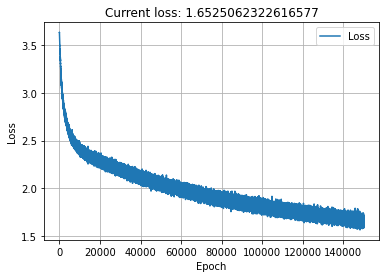

100%|██████████| 50000/50000 [1:12:32<00:00, 11.49it/s]

Test text: ' there are new thine eyes do sould every with the world thy seeming so the still that the love, and '


In [30]:
train_loss_lst = []
plot_tick = 100

for i in tqdm(range(n_epochs)):
    batch_ix = to_matrix(sample(sequences, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq = rnn_loop(model, batch_ix)
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(predictions_logp.reshape(-1, dict_size), actual_next_tokens.reshape(-1))
    
    # train with backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss_lst.append(loss.data.to('cpu').numpy())

    if (i + 1) % plot_tick == 0:
        clear_output(True)
        plt.plot(train_loss_lst, label='Loss')
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f"Current loss: {np.mean(train_loss_lst[-plot_tick:])}")
        plt.show()
        
        test_text = generate_text(model, seed_phrase=' there are', max_length=MAX_LENGTH, temperature=0.5)
        print(f"Test text: '{test_text}'")

assert np.mean(train_loss_lst[:10]) > np.mean(train_loss_lst[-10:]), "RNN didn't converge."

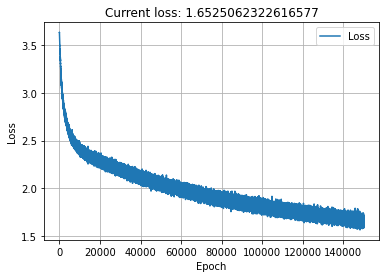

In [31]:
plt.plot(train_loss_lst, label='Loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Current loss: {np.mean(train_loss_lst[-100:])}")
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [32]:
seed_text = sequences[0][:13]
print('Real text:\n')
print(sequences[0])
seed_text = ''.join(seed_text)
print(f'text seed: {seed_text}')

Real text:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the ri
text seed: from fairest 


In [33]:
length = 500
temperature_lst = [0.1, 0.2, 0.5, 1.0, 2.0]
for temperature in temperature_lst:
    print(f"Temperature: {temperature}\nText:\n")
    print(generate_text(model, seed_text, length, temperature))
    print()

Temperature: 0.1
Text:



/home/aslan/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/aslan/anaconda3/envs/dl_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


from fairest the self the worth the self the worth the worth the self thee the worth the seem thee thee thee thee thee thee thee thee thee thee thee thee in the seem the worth the with the stant the worth the seem thee thee thee thee thee thee thee thee in the seem thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee in the seem so the some thee in th

Temperature: 0.2
Text:

from fairest the seem the worth thou the seem be the worther thee thee in the self the seem thee thee be thee thee thee thee thee thee thee thee thee thee in my self the seem be thee in the seem the worth the worth the self the worth the worth the worth in the with the beauty the self love the seem thee thee thee in the self thee thee thee thee thee thee thee the with the will my shall the worth the worth the seem the love the worth the will the seem the strange the see

Результат работы LSTM для temperature=0.5 получился достаточно неплохим.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here
RNN_PATH = os.path.join('models', 'torch_rnn.model')
LSTM_PATH = os.path.join('models', 'torch_lstm.model')

In [ ]:
torch.save(model_rnn, RNN_PATH)
torch.save(model, LSTM_PATH)

In [ ]:
model_rnn = VanilaRNN()
model_rnn.load_state_dict(torch.load(RNN_PATH))

model = LSTM()
model.load_state_dict(torch.load(LSTM_PATH))

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)